In [1]:
import cv2,os
import math
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict

import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from torch.nn import functional as F
from Scripts.utils import ellipse, rectangle, rotate, ZeroPaddingResizeCV
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)", flush=True)
    print("torch.cuda.device_count(): ", torch.cuda.device_count(), flush=True)
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(), flush=True)
    print("torch.cuda.current_device()", torch.cuda.current_device(), flush=True)
else:
    device = torch.device("cpu")
    print("torch.device(cpu)", flush=True)

torch.device(cuda)
torch.cuda.device_count():  1
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 0.0 GradCAM
* this code is used by: https://github.com/jacobgil/pytorch-grad-cam
* Example: https://colab.research.google.com/drive/1UKcvOL_5sdDPJKU69MiADp8Y1-e24vz9?usp=sharing#scrollTo=AlrrU_yW9ZCX

In [51]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image,preprocess_image
from torchvision.models import resnet50

def predict(model,input_tensor,true_y):
    model.eval()
    output = model(input_tensor)
    pre_y = output.argmax(1).cpu().item()
    return pre_y==true_y, pre_y

def gradcams(model,input_tensor,target_layers,imgpad,optioncam):
    # GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    if optioncam=="GradCAM":
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="ScoreCAM":
        cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="GradCAMPlusPlus":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="AblationCAM":
        cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="XGradCAM":
        cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="EigenCAM":
        cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="FullGrad":
        cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
    else:
        return print("your option is not support")
    # Note: input_tensor can be a batch tensor with several images!
    # If None, returns the map for the highest scoring category. 
    # Otherwise, targets the requested index. target_index = 1
    targets = None
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets,aug_smooth=True,eigen_smooth=True)
    grayscale_cam = cam(input_tensor, targets)[0]
    # In this example grayscale_cam has only one image in the batch:
    visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=False)
    
    # Guided-GradCAM
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, targets)
    if np.amax(gb)!=0:
        gb = np.maximum(gb,0)*(1/np.amax(gb))
    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = cam_mask * gb
    
    return visualization,gb,cam_gb,cam_mask

# 0. Load Data and Model

In [26]:
chip="CTCF"
resnet="Resnet10_noavg"

In [27]:
X_Ctrl = np.load(f"./Datasets/CTRL_{chip}.npy",allow_pickle=True)
X_Rett = np.load(f"./Datasets/RETT_{chip}.npy",allow_pickle=True)
chip_li = ["All", "H3K27ac", "CTCF", "Dapi"]

In [28]:
weight_path = f"./results/{chip}_{resnet}/{chip}_{resnet}_Fold0.pkl"
weight=torch.load(weight_path)
print(weight_path)
if resnet=="Resnet10_noavg":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.layer3 = nn.Sequential()
            self.resnet.layer4 = nn.Sequential()
            self.resnet.avgpool = nn.Sequential()
            self.resnet.fc = nn.Linear(128*63*63, 2)
            self.resnet.load_state_dict(weight)
        def forward(self, x):
            x = self.resnet(x)
            return x
elif resnet=="Resnet10":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.layer3 = nn.Sequential()
            self.resnet.layer4 = nn.Sequential()
            self.resnet.fc = nn.Linear(128, 2)
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
elif resnet=="Resnet18":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.fc = nn.Linear(512, 2)
            self.resnet.load_state_dict(weight)
        def forward(self, x):
            x = self.resnet(x)
            return x
    
model = ResNet().to(device)

./results/CTCF_Resnet10_noavg/CTCF_Resnet10_noavg_Fold0.pkl


# 1. GradCAM heatmap in samples 

In [36]:
model.resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_s

In [39]:
target_layers = [model.resnet.layer2]
# cam's option: GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, ScoreCAM, FullGrad
optioncam = "ScoreCAM"
target_layers

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
     (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
     (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(128, eps=1e-05, mo

## 1.0 abstract

NameError: name 'cam_mask' is not defined

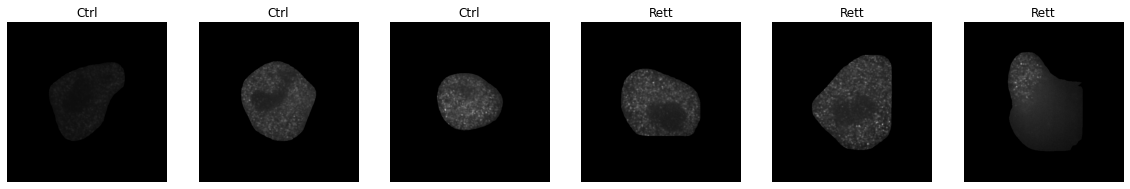

<Figure size 1440x1440 with 0 Axes>

In [52]:
def title(label):
    if label==0:
        return "Ctrl"
    else:
        return "Rett"
Visual_sample = []
index = [0,1,2]
for i in index:
    img = X_Ctrl[i]
    Visual_sample.append(img)
index = [0,1,2]
for i in index:
    img = X_Rett[i]
    Visual_sample.append(img)

Visual_sample = np.array(Visual_sample)
y_Visual_sample = torch.tensor([0,0,0,1,1,1], dtype=torch.int64)
plt.figure(figsize=(20,20))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.title(title(y_Visual_sample[i]))
    plt.axis("off")
    plt.imshow(Visual_sample[i])
    
plt.figure(figsize=(20,20))
for n in range(6):
    img = Visual_sample[n]
    img = np.float32(img)/255
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,y_Visual_sample[n])
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    plt.subplot(1,6,n+1)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(cam, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(20,20))
for n in range(6):
    img = Visual_sample[n]
    img = np.float32(img)/255
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,y_Visual_sample[n])
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    plt.subplot(1,6,n+1)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))

## 1.1 samples of untreated

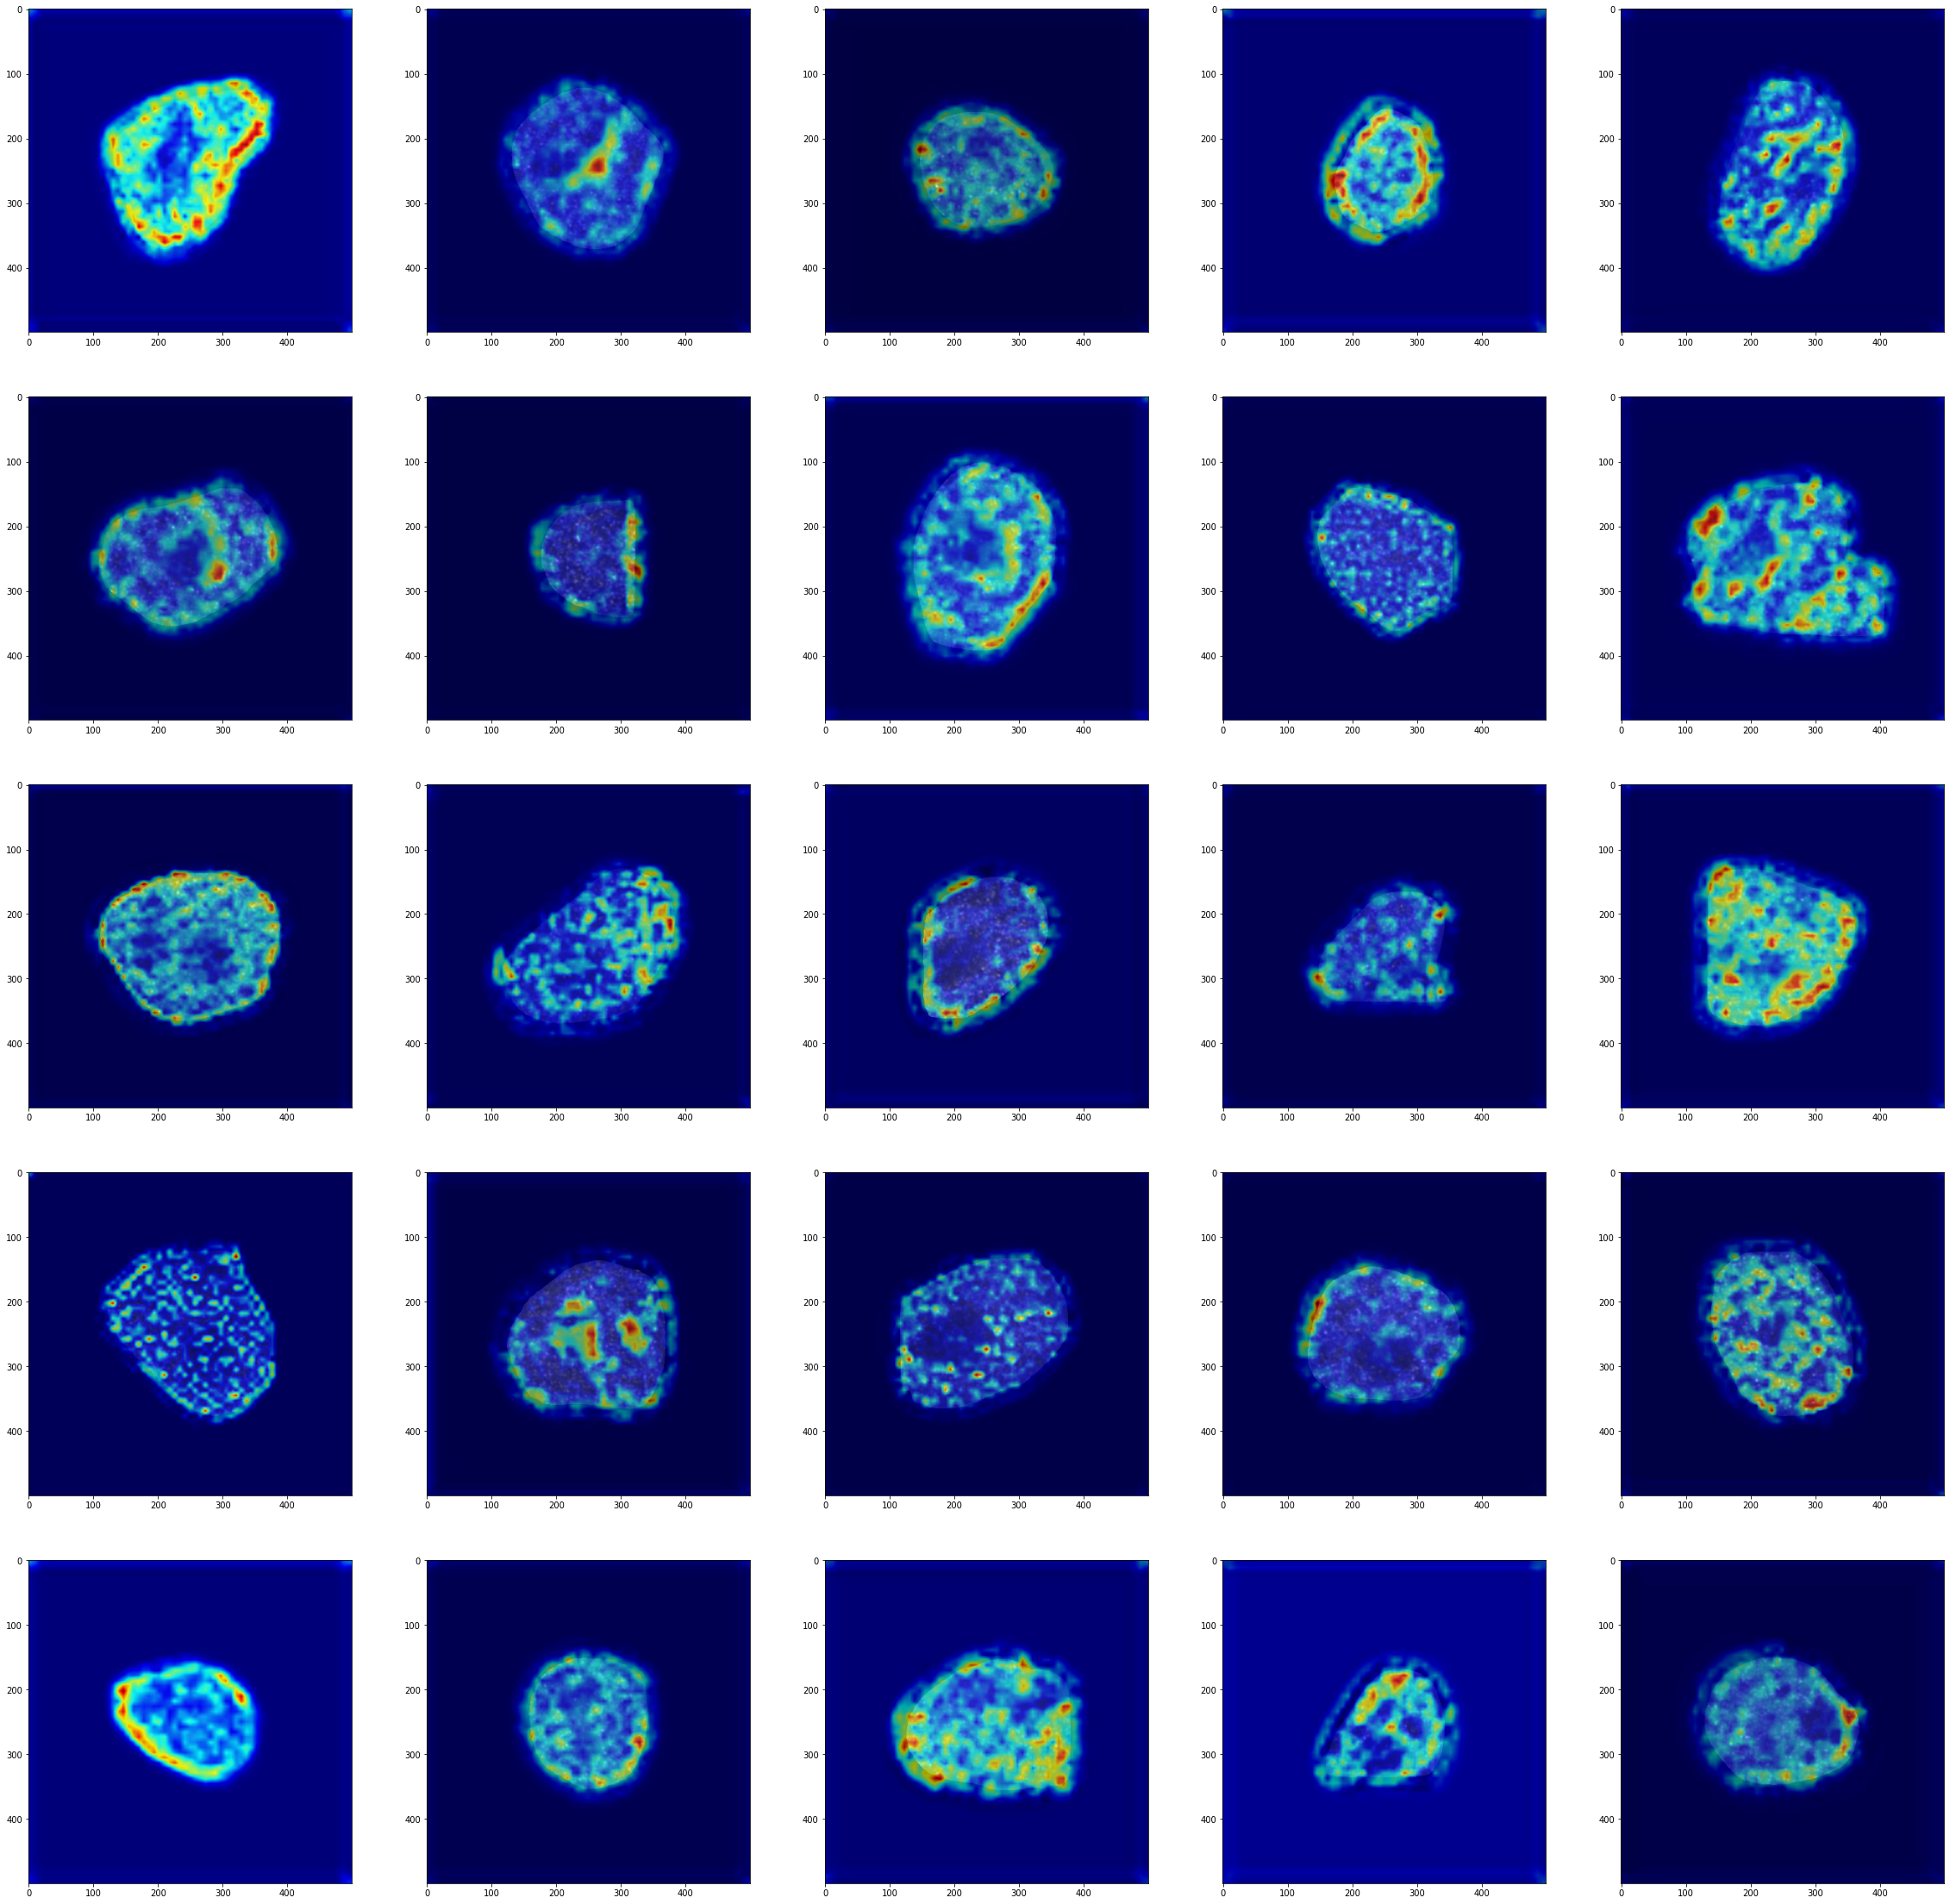

In [41]:
true_y = 0
times=0
fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in range(25):
    img = X_Ctrl[n]
    result, angle = ellipse(img)
    x, y, w, h = rectangle(result)
    img = np.float32(img)/255
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#     heatmap[heatmap<0.5]=0
#     if np.amax(cam)!=0:
    if 1:
        if times < 25:
            times+=1
            plt.subplot(5,5,times)
#             plt.title(str(tf)+str(heatmap.max()))
            plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
        else:
            break
    else:
        print("CAM heatmap is empty, ", n)

## 1.2 samples of VPA

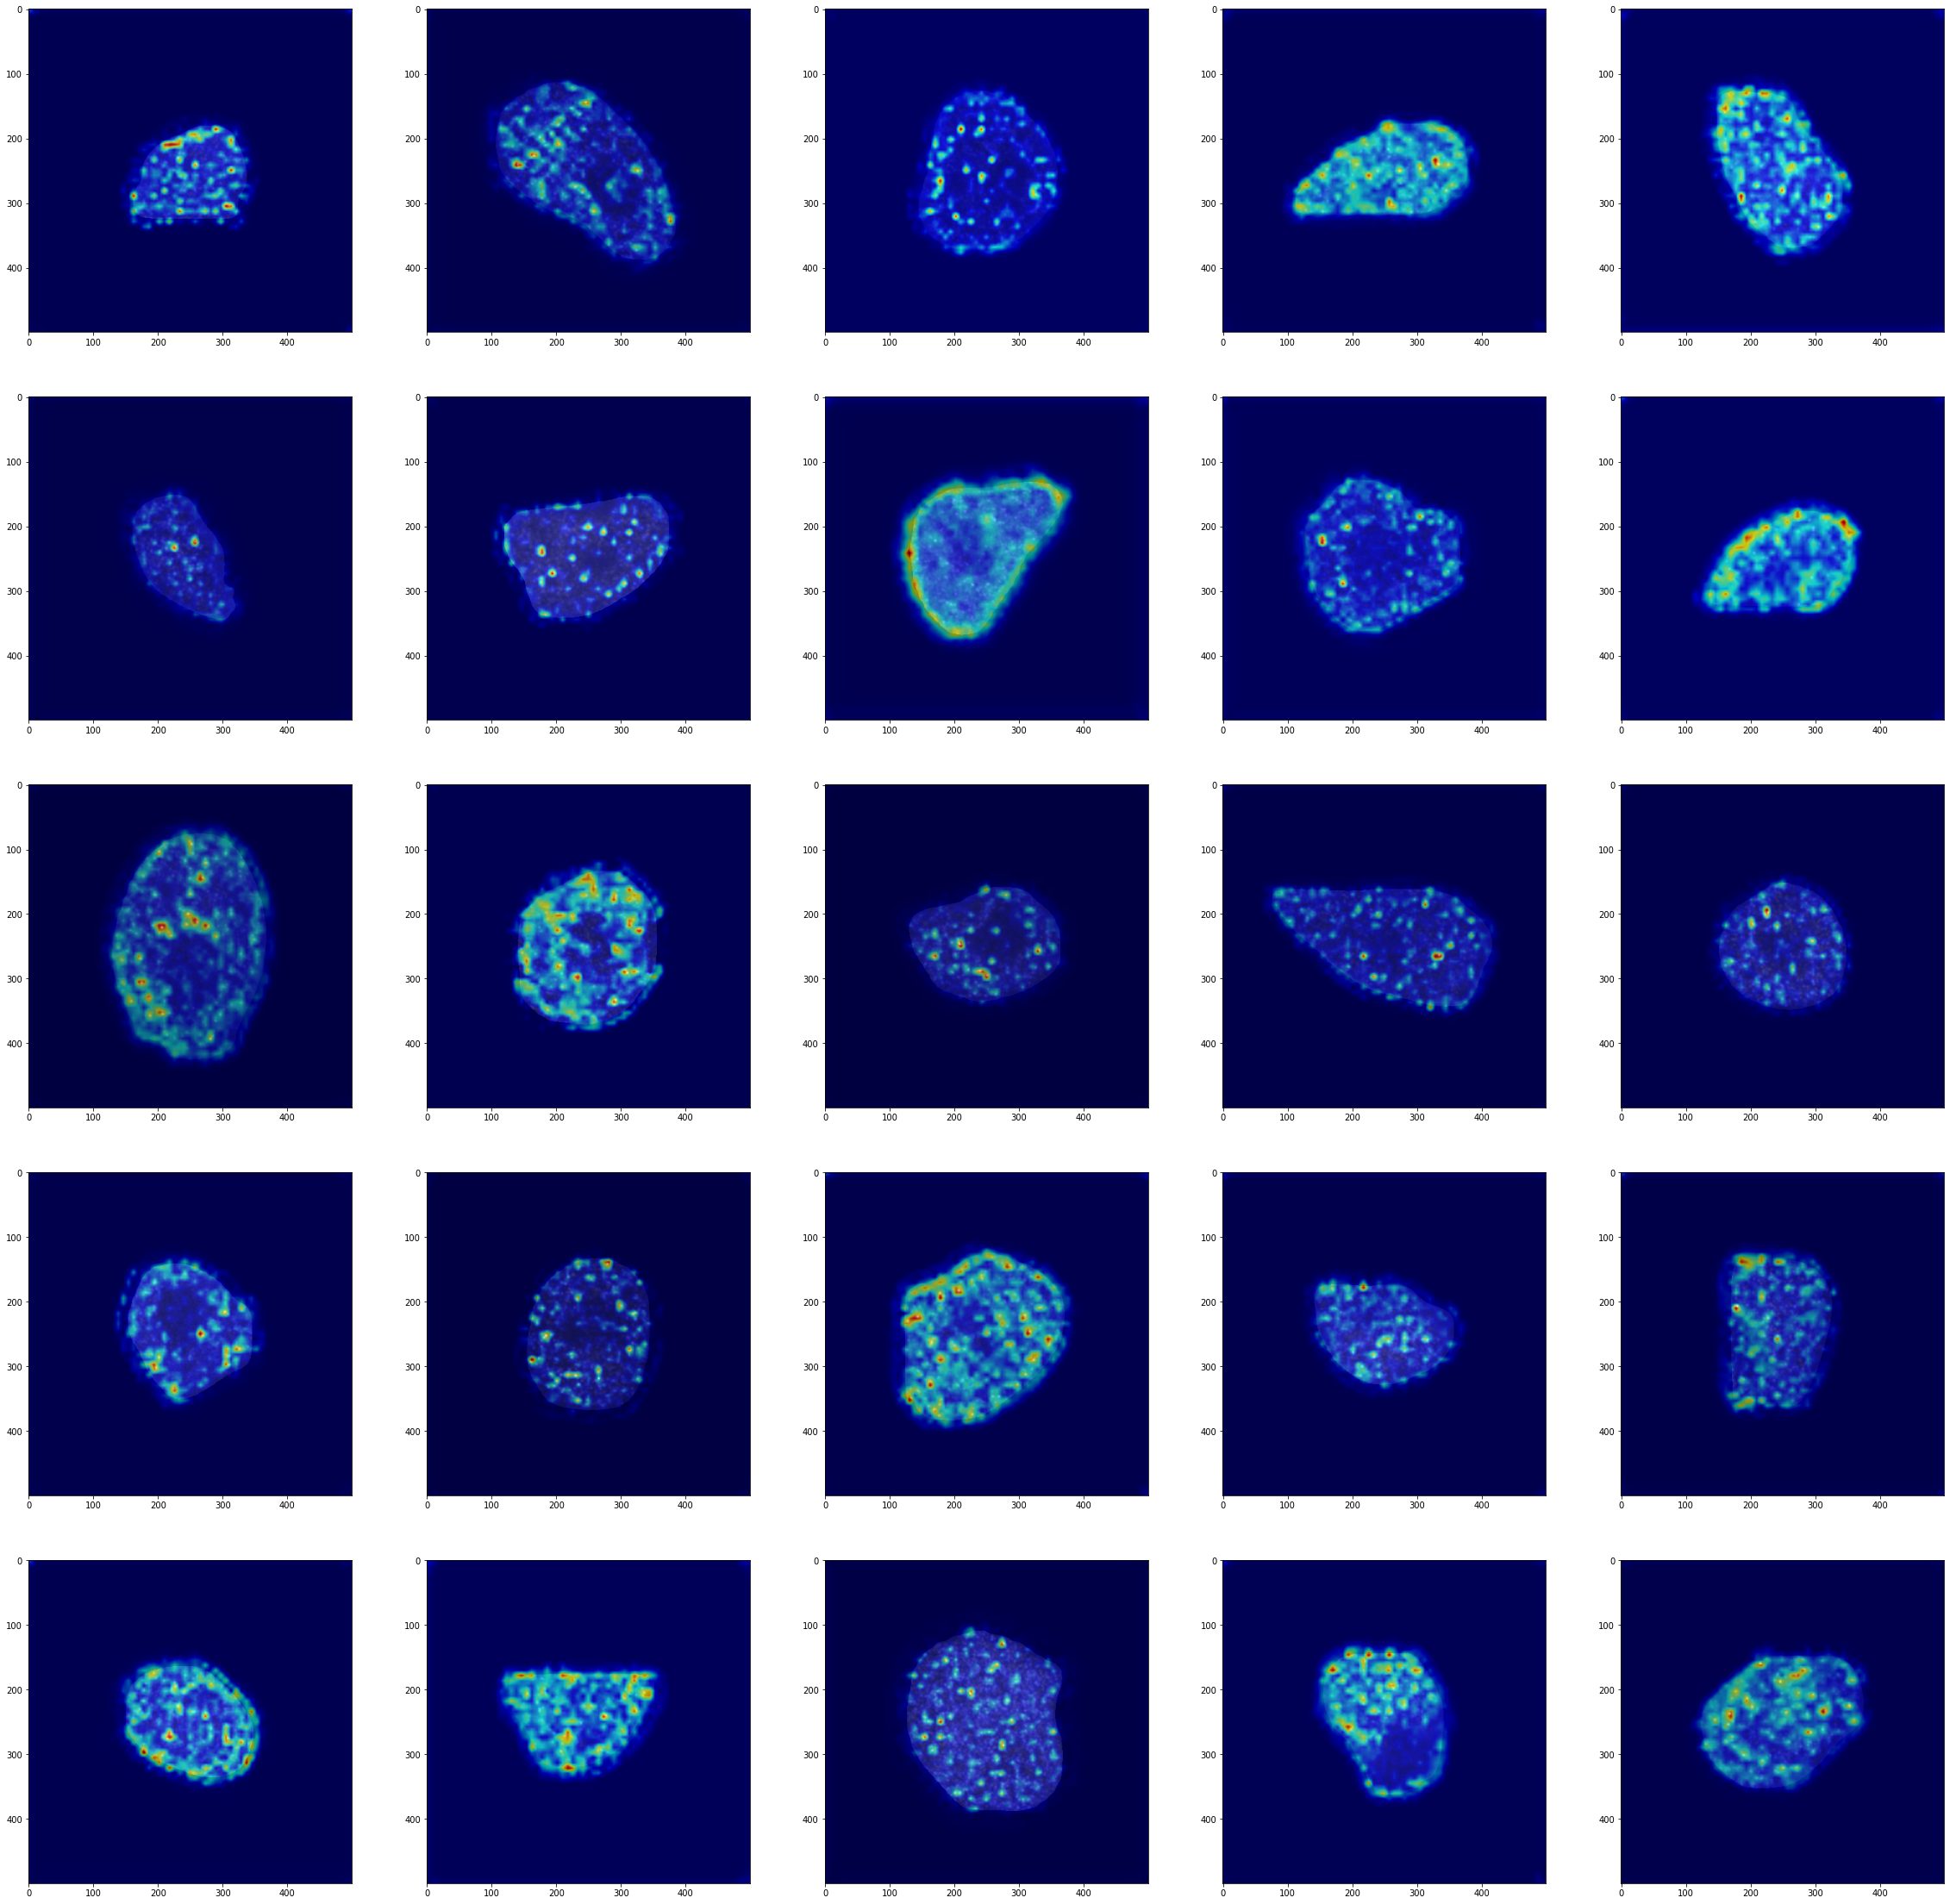

In [42]:
true_y = 1
fig, ax = plt.subplots(5,5, figsize = (40,40))
times=0
for n in range(50,200):
    img = X_Rett[n]
    result, angle = ellipse(img)
    x, y, w, h = rectangle(result)
    img = np.float32(img)/255

    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#     heatmap[heatmap<0]=0
#     if np.amax(cam)!=0:
    if 1:
        if times < 25:
            times+=1
            plt.subplot(5,5,times)
#             plt.title(str(tf)+str(heatmap.max()))
            plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
        else:
            break
    else:
        print("CAM heatmap is empty, ", n)

# 2. Guided-GradCAM in samples

## 2.1 Gb samples of untreated

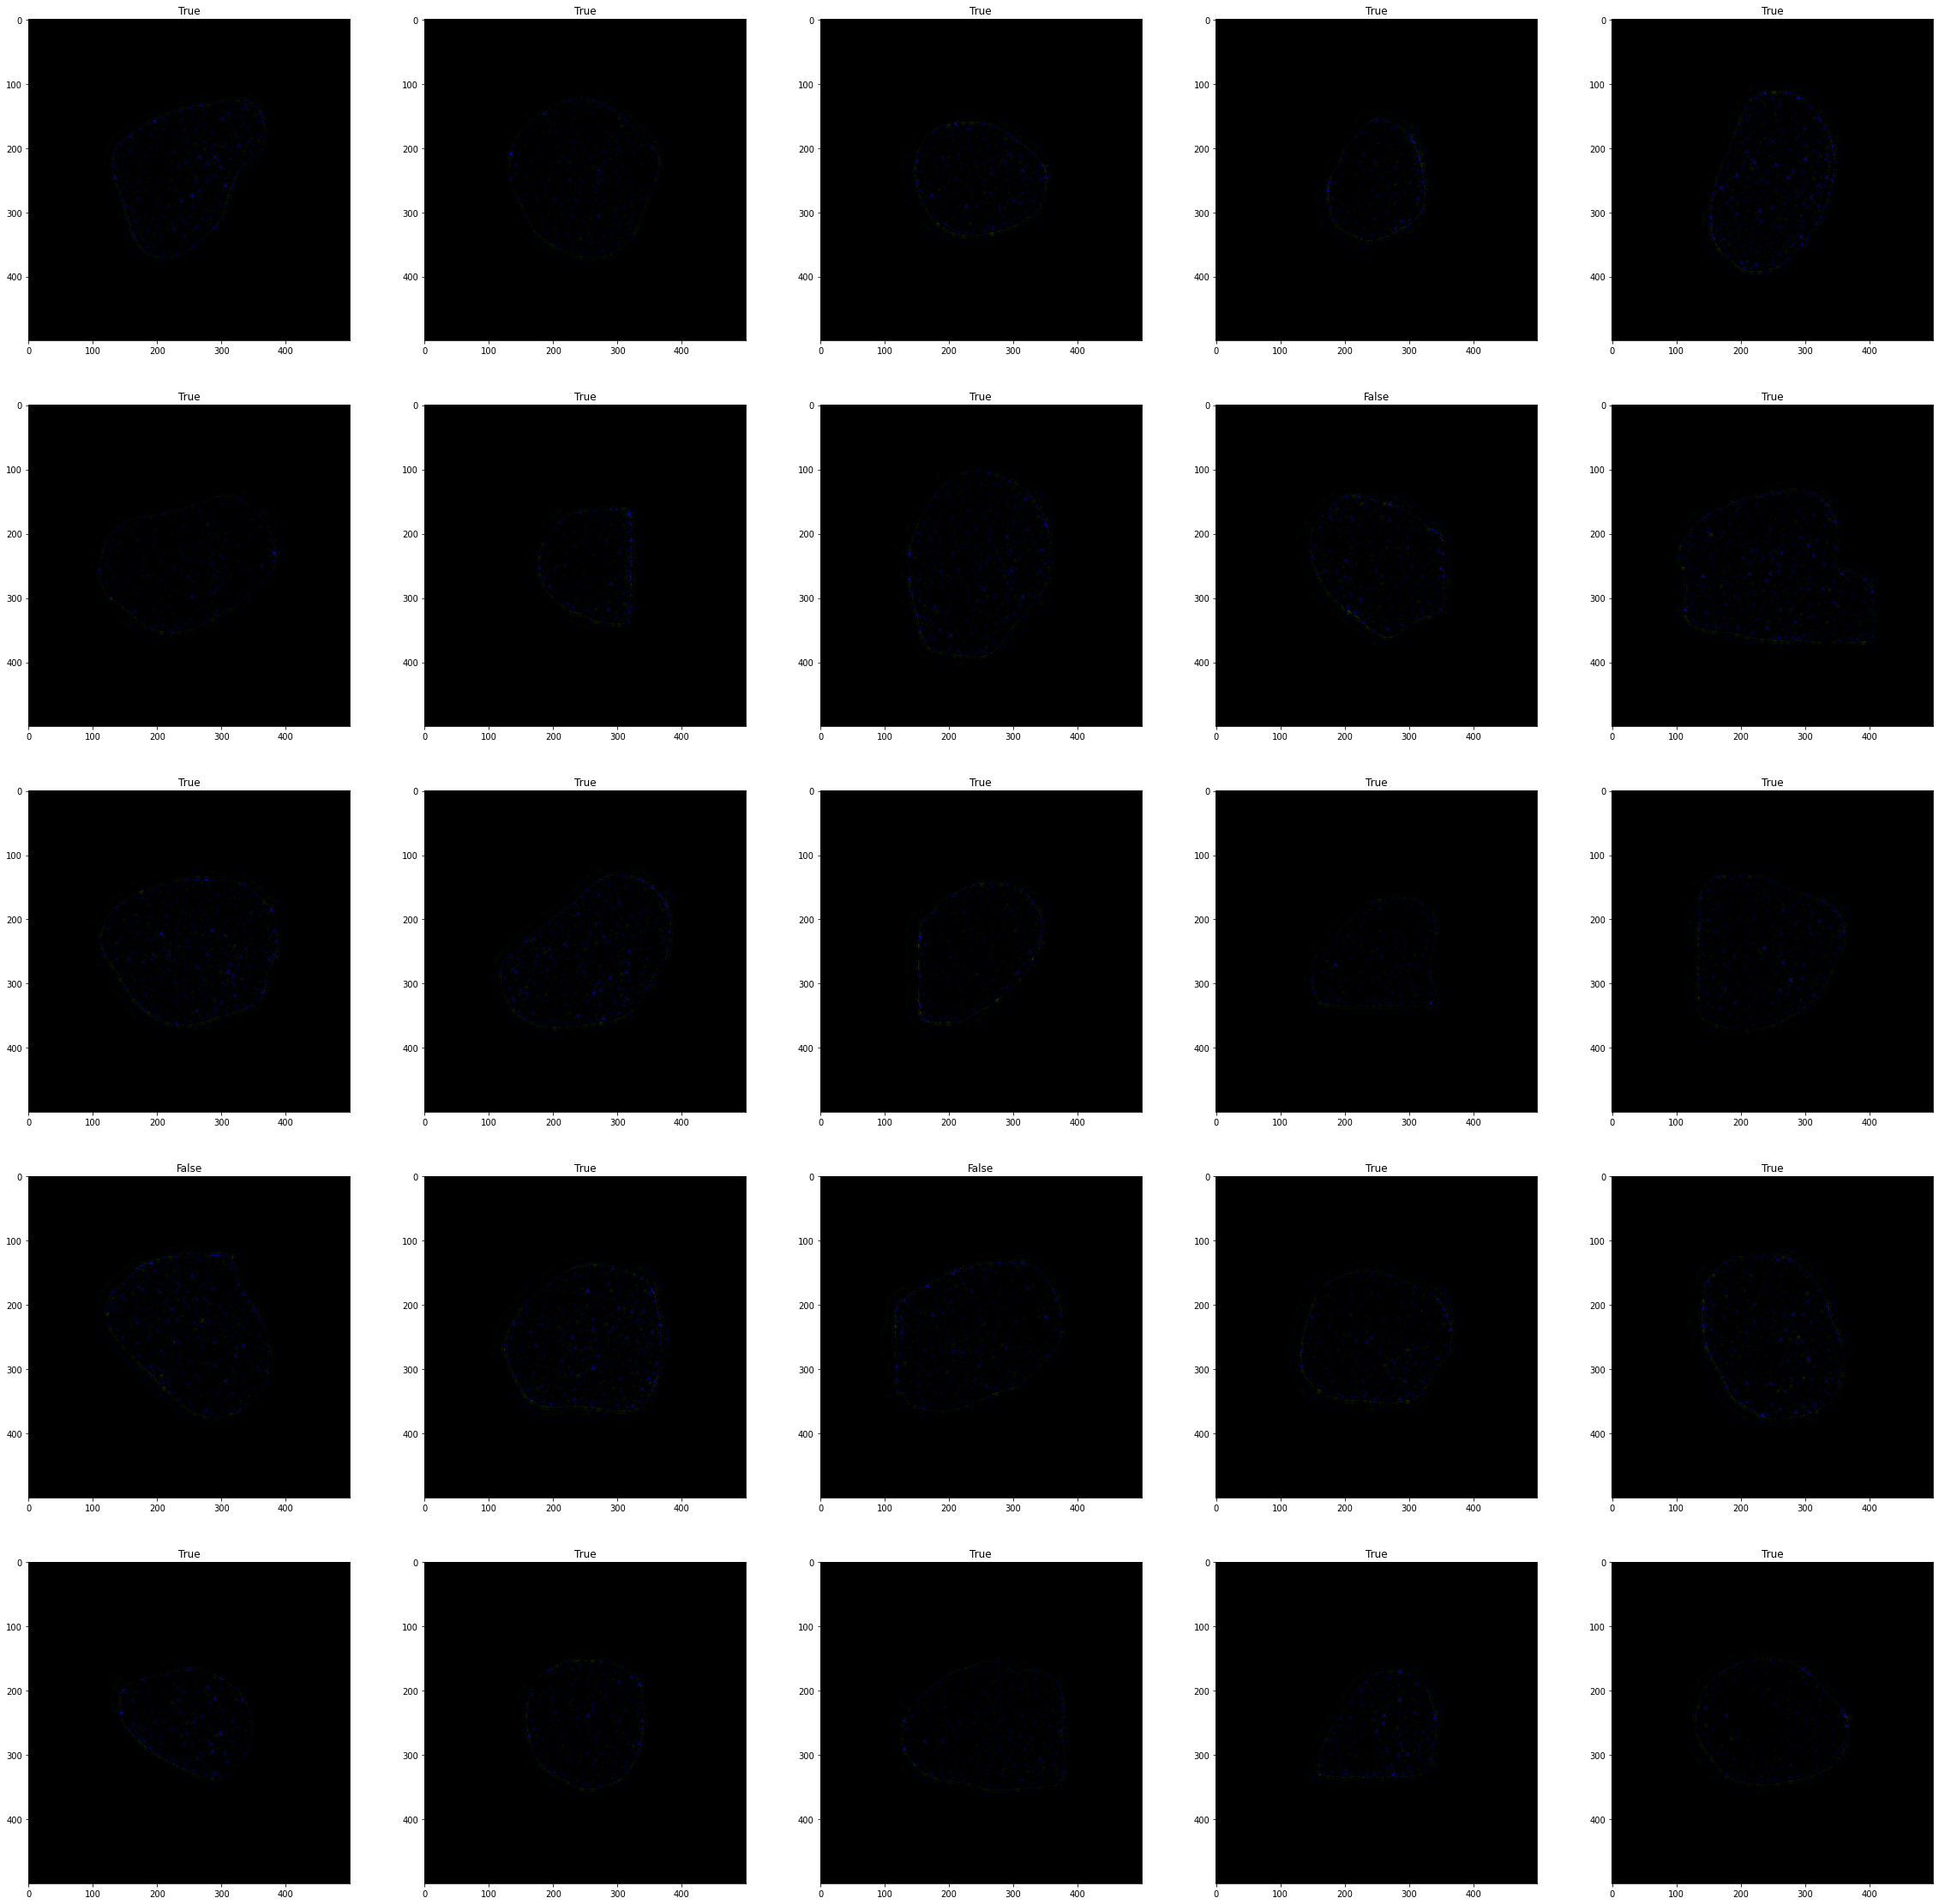

In [43]:
true_y = 0
fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in range(25):
    img = X_Ctrl[n]
    img = np.float32(img)/255

    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)

    plt.subplot(5,5,n+1)
    plt.title(tf)
    plt.imshow(cv2.cvtColor(gb, cv2.COLOR_BGR2RGB))

## 2.2 Gb samples of RETT

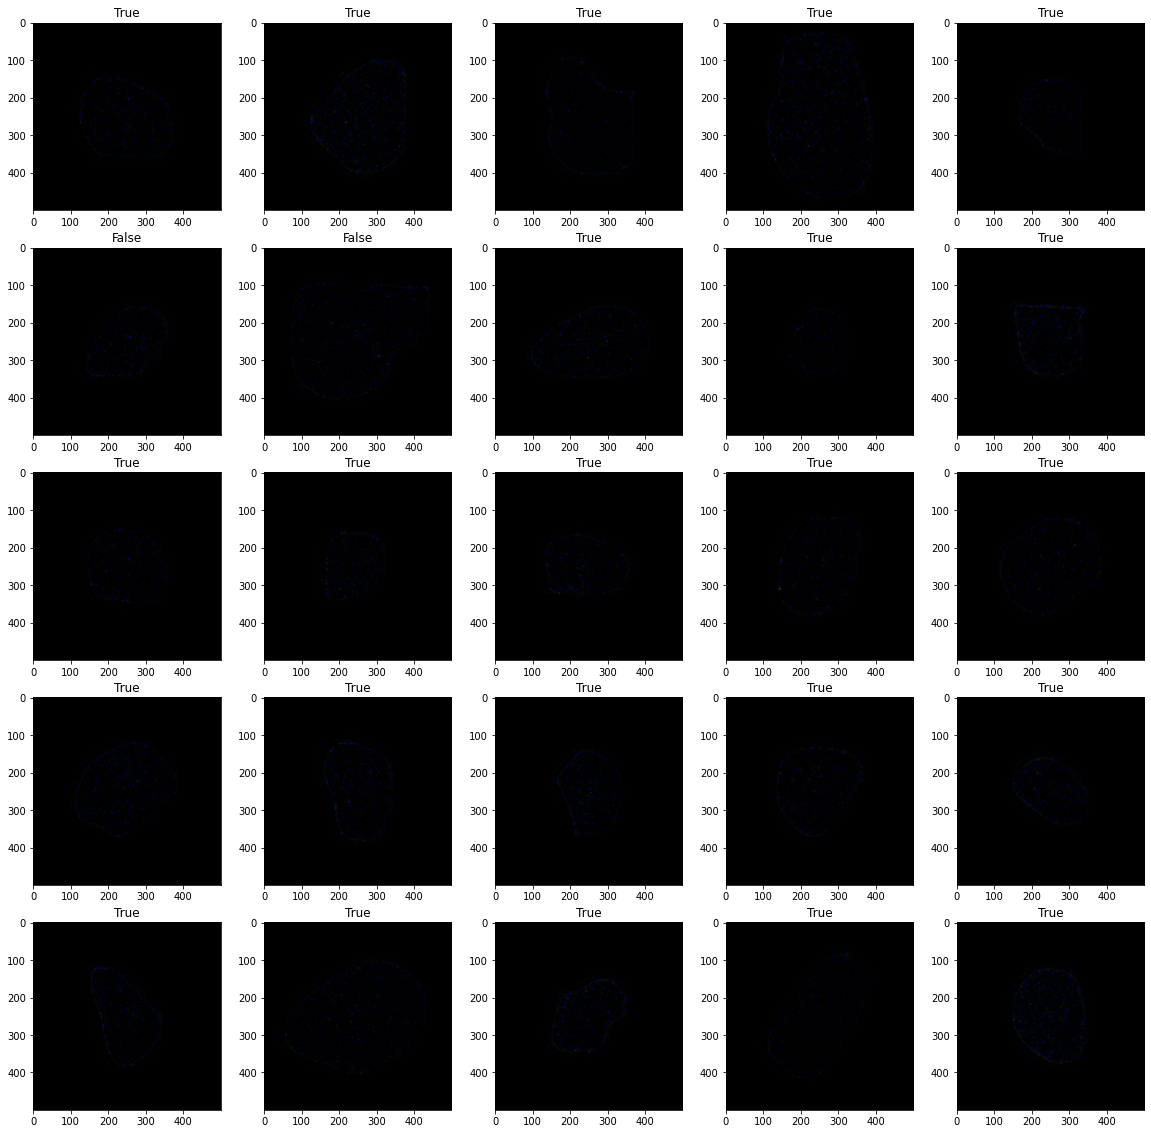

In [44]:
true_y = 1
fig, ax = plt.subplots(5,5, figsize = (20,20))
for n in range(25):
        img=X_Rett[n]
        img = np.float32(img)/255

        transform = transforms.Compose([transforms.ToTensor()])
        input_tensor = transform(img).unsqueeze(0).to(device)

        tf,pred = predict(model,input_tensor,true_y)
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
        
        plt.subplot(5,5,n+1)
        plt.title(tf)
        plt.imshow(cv2.cvtColor(gb, cv2.COLOR_BGR2RGB))

# 3. Average of GradCAM heatmap

## 3.0 processing function

In [22]:
def ellipse(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0 , 255, cv2.THRESH_BINARY)[1]
    contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    big_contour = max(contours, key=cv2.contourArea)
    ellipse = cv2.fitEllipse(big_contour)
    (xc,yc),(d1,d2),angle = ellipse
    result = img.copy()
    cv2.ellipse(result, ellipse, (0, 255, 0), 3)
    xc, yc = ellipse[0]
    cv2.circle(result, (int(xc),int(yc)), 10, (255, 255, 255), -1)
    rmajor = max(d1,d2)/2
    if angle > 90:
        angle = angle - 90
    else:
        angle = angle + 90
    xtop = xc + math.cos(math.radians(angle))*rmajor
    ytop = yc + math.sin(math.radians(angle))*rmajor
    xbot = xc + math.cos(math.radians(angle+180))*rmajor
    ybot = yc + math.sin(math.radians(angle+180))*rmajor
    cv2.line(result, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 0, 255), 3)
    return result, angle

In [23]:
def rectangle(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0 , 255, cv2.THRESH_BINARY)[1]
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x, y, w, h = cv2.boundingRect(cnt)
    return x, y, w, h

In [24]:
def rotate(img, angle):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    rotated = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(img, rotated, (w, h))
    return rotated

In [25]:
def ZeroPaddingResizeCV(img, size=(600, 600), interpolation=None, n=3):
    isize = img.shape
    ih, iw = isize[0], isize[1]
    h, w = size[0], size[1]
    scale = min(w / iw, h / ih)
    new_w = int(iw * scale + 0.5)
    new_h = int(ih * scale + 0.5)
 
    img = cv2.resize(img, (new_w, new_h), interpolation)
    if n==3:
        new_img = np.zeros((h, w, n), np.uint8)
        new_img[(h-new_h)//2:(h+new_h)//2, (w-new_w)//2:(w+new_w)//2] = img
    else:
        new_img = np.zeros((h, w), np.float32)
        new_img[(h-new_h)//2:(h+new_h)//2, (w-new_w)//2:(w+new_w)//2] = img
    return new_img

In [22]:
# X = [X_Ctrl[1],X_Ctrl[3],X_Ctrl[7],X_Ctrl[11],X_Ctrl[16],X_Ctrl[19]]
X = [X_VPA[1],X_VPA[3],X_VPA[7],X_VPA[11],X_VPA[16],X_VPA[19]]

In [24]:
# plt.figure(figsize=(20,20))
# for n in range(6):
#     img = np.zeros([600,600,3],dtype=np.uint8)
#     img[:,:,0] = X[n][:,:,0]
#     plt.imshow(img)
#     cv2.imwrite("figures/Fig3.c.original.tif",img)
    
# plt.figure(figsize=(20,20))
# for n in range(6):
#     img = np.zeros([600,600,3],dtype=np.uint8)
#     img[:,:,0] = X[n][:,:,0]
#     result, angle = ellipse(img)
#     plt.subplot(1,6,n+1)
#     plt.title("angle: {:1f}".format(angle))
#     plt.imshow(result)
#     cv2.imwrite("figures/Fig_S3.b.angle.tif",result)

# plt.figure(figsize=(20,20))
# for n in range(6):
#     img = np.zeros([600,600,3],dtype=np.uint8)
#     img[:,:,0] = X[n][:,:,0]
#     result, angle = ellipse(img)
#     result = rotate(result, angle-45)
#     plt.subplot(1,6,n+1)
#     plt.title("angle: 45")
#     plt.imshow(result)
#     cv2.imwrite("figures/Fig_S3.c.rotate.tif",result)
    
# plt.figure(figsize=(20,20))
# for n in range(6):
#     img = np.zeros([600,600,3],dtype=np.uint8)
#     img[:,:,0] = X[n][:,:,0]
#     result, angle = ellipse(img)
#     result = rotate(result, angle-45)
#     x, y, w, h = rectangle(result)
#     result = result[y:y+h,x:x+w]
#     result = ZeroPaddingResizeCV(result, size=(600, 600))
#     plt.subplot(1,6,n+1)
#     plt.title("zoomed and rotated")
#     plt.imshow(result)
#     cv2.imwrite("figures/Fig_S3.d.zoom.tif",result)

In [47]:
# n = 7
# cam = pltcam(X_RETT[n], 1, chip_li[1])

# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray, 0 , 1, cv2.THRESH_BINARY)[1]
# mask = thresh.copy()
# h, w = thresh.shape[:2]
# scale = 0.95
# new_h, new_w = int(h * scale), int(w * scale)
# pad = (h - new_h) // 2
# resized = cv2.resize(cam, (new_w, new_h))
# cam_pad = cv2.copyMakeBorder(resized, top=pad, bottom=pad, left=pad, right=pad, borderType=cv2.BORDER_CONSTANT, value=[0,0,0])

# cam_pad*=thresh
# plt.axis("off")
# plt.imshow(cam_pad)
# plt.show()
# print(cam_pad.shape)

# plt.imshow(cam_pad)
# plt.axis("off")
# plt.show()
# cv2.imwrite("figures/Fig3.b.cam.tif",cam_pad)

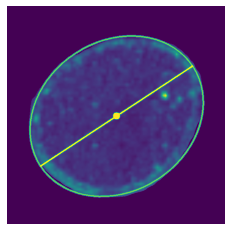

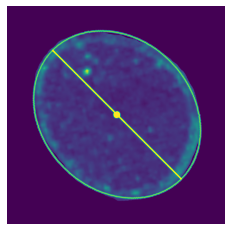

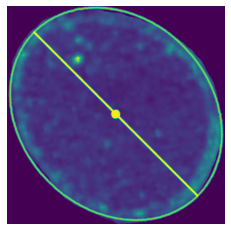

True

In [95]:
n = 7
img = X_VPA[n]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0 , 255, cv2.THRESH_BINARY)[1]
contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)
ellipse = cv2.fitEllipse(big_contour)
(xc,yc),(d1,d2),angle = ellipse

result = cam_pad.copy()*255
cv2.ellipse(result, ellipse, 200, 3)
xc, yc = ellipse[0]
cv2.circle(result, (int(xc),int(yc)), 10, 255, -1)
rmajor = max(d1,d2)/2
if angle > 90:
    angle = angle - 90
else:
    angle = angle + 90
xtop = xc + math.cos(math.radians(angle))*rmajor
ytop = yc + math.sin(math.radians(angle))*rmajor
xbot = xc + math.cos(math.radians(angle+180))*rmajor
ybot = yc + math.sin(math.radians(angle+180))*rmajor
cv2.line(result, (int(xtop),int(ytop)), (int(xbot),int(ybot)), 255, 3)
plt.axis("off")
plt.imshow(result)
plt.show()
cv2.imwrite("figures/Fig3.b.cam_ellipse.png",result)

result = rotate(result, angle-45)
plt.axis("off")
plt.imshow(result)
plt.show()
cv2.imwrite("figures/Fig3.b.cam_rotate.png",result)

result = ZeroPaddingResizeCV(result[y:y+h,x:x+w], size=(600, 600),n=1)
plt.axis("off")
plt.imshow(result)
plt.show()
cv2.imwrite("figures/Fig3.b.cam_zoom.png",result)

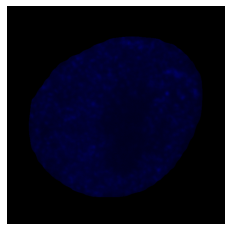

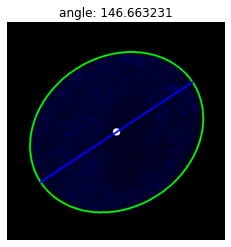

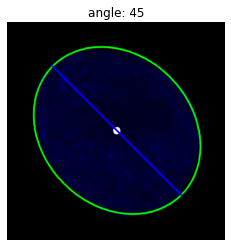

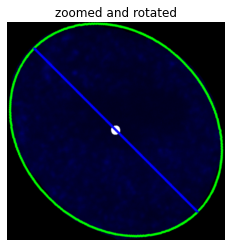

True

In [92]:
# plt.figure(figsize=(20,20))
n = 7
img = np.zeros([600,600,3],dtype=np.uint8)
img[:,:,2] = X_VPA[n][:,:,0]
plt.imshow(img)
plt.axis("off")
plt.show()
cv2.imwrite("figures/Fig3.b.original.tif",img)

img = np.zeros([600,600,3],dtype=np.uint8)
img[:,:,2] = X_VPA[n][:,:,0]
result, angle = ellipse(img)
plt.title("angle: {:1f}".format(angle))
plt.imshow(result)
plt.axis("off")
plt.show()
cv2.imwrite("figures/Fig3.b.angle.tif",result)

img = np.zeros([600,600,3],dtype=np.uint8)
img[:,:,2] = X_VPA[n][:,:,0]
result, angle = ellipse(img)
result = rotate(result, angle-45)
plt.title("angle: 45")
plt.imshow(result)
plt.axis("off")
plt.show()
cv2.imwrite("figures/Fig3.b.rotate.tif",result)
    
img = np.zeros([600,600,3],dtype=np.uint8)
img[:,:,2] = X_VPA[n][:,:,0]
result, angle = ellipse(img)
result = rotate(result, angle-45)
x, y, w, h = rectangle(result)
result = result[y:y+h,x:x+w]
result = ZeroPaddingResizeCV(result, size=(600, 600))
plt.title("zoomed and rotated")
plt.imshow(result)
plt.axis("off")
plt.show()
cv2.imwrite("figures/Fig3.b.zoom.tif",result)

In [12]:
# img = X_Ctrl[n]
# result, angle = ellipse(img)
# x, y, w, h = rectangle(result)
# img = np.float32(img)/255
# transform = transforms.Compose([transforms.ToTensor()])
# input_tensor = transform(img).unsqueeze(0).to(device)
# tf,pred = predict(model,input_tensor,true_y)
# visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer2[1].conv2],img,optioncam)
# plt.figure(figsize=(10,10))
# plt.subplot(1,4,1)
# plt.imshow(img)
# plt.subplot(1,4,2)
# plt.imshow(rotate(result, angle-45))
# plt.subplot(1,4,3)
# plt.imshow(rotate(result, angle-45)[y:y+h,x:x+w])
# plt.subplot(1,4,3)
# plt.imshow(rotate(result, angle-45)[y:y+h,x:x+w])
# plt.subplot(1,4,4)
# plt.imshow(ZeroPaddingResizeCV(rotate(result, angle-45)[y:y+h,x:x+w], size=(600, 600)))

# plt.figure(figsize=(10,10))
# plt.subplot(1,4,1)
# plt.imshow(cam[:,:,0])
# plt.subplot(1,4,2)
# plt.imshow(rotate(cam[:,:,0], angle-45))
# plt.subplot(1,4,3)
# plt.imshow(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w])
# plt.subplot(1,4,4)
# plt.imshow(ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1))

In [75]:
optioncam = "GradCAM"
# optioncam = "ScoreCAM"

## 3.1 average in untreated

In [88]:
true_y = 0
count = 0
intensity00_conv1 = []
intensity00_layer1 = []
intensity00_layer2 = []
intensity00_layer3 = []
intensity00_layer4 = []
intensity00_gb = []
total = 10

for n in tqdm(range(total)):
    img = X_Ctrl[n]
    result, angle = ellipse(img)
    x, y, w, h = rectangle(result)
    img = np.float32(img)/255
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.conv1],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity00_conv1.append(heatmap)
        
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer1],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity00_layer1.append(heatmap)
        
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer2],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity00_layer2.append(heatmap)

#         visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer3[1].conv2],img,optioncam)
#         intensity00_layer3+=ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer4[1].conv2],img,optioncam)
#         intensity00_layer4+=ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
        heatmap = ZeroPaddingResizeCV(rotate(gb[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity00_gb.append(heatmap)

        count+=1
intensity00_conv1 = np.array(intensity00_conv1)
intensity00_layer1 = np.array(intensity00_layer1)
intensity00_layer2 = np.array(intensity00_layer2)
intensity00_gb = np.array(intensity00_gb)
print("intensity00_layer2.shape: ", intensity00_layer2.shape)
print("Data00 acc: {:.3f}, count: {:}, total: {:} " .format(count/total,count,total))

100%|██████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]

intensity00_layer2.shape:  (10, 600, 600)
Data00 acc: 1.000, count: 10, total: 10 


In [84]:
print(intensity00_layer2.shape)

(18600, 600)


In [85]:
print(heatmap.shape)

(600, 600)


In [ ]:

plt.figure(figsize=(20,20))
plt.subplot(1,6,1)
plt.title(intensity00_conv1.max())
plt.imshow(intensity00_conv1)
plt.subplot(1,6,2)
plt.title(intensity00_layer1.max())
plt.imshow(intensity00_layer1)
plt.subplot(1,6,3)
plt.title(intensity00_layer2.max())
plt.imshow(intensity00_layer2)
plt.subplot(1,6,4)
plt.title(intensity00_gb.max())
# plt.imshow(intensity00_layer3)
# plt.subplot(1,6,5)
# plt.imshow(intensity00_layer4)
# plt.subplot(1,6,6)
plt.imshow(intensity00_gb)

## 3.2 average in VPA

In [ ]:
true_y = 1
count = 0
intensity01_conv1 = np.zeros((600,600))
intensity01_layer1 = np.zeros((600,600))
intensity01_layer2 = np.zeros((600,600))
intensity01_layer3 = np.zeros((600,600))
intensity01_layer4 = np.zeros((600,600))
intensity01_gb = np.zeros((600,600))
total = 3000

for n in tqdm(range(total)):
    img = X_VPA[n]
    result, angle = ellipse(img)
    x, y, w, h = rectangle(result)
    img = np.float32(img)/255
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.conv1],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity01_conv1+=heatmap

        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer1],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity01_layer1+=heatmap
        
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer2],img,optioncam)
        heatmap = ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity01_layer2+=heatmap
        
#         visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer3[1].conv2],img,optioncam)
#         intensity01_layer3+=ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.resnet.layer4[1].conv2],img,optioncam)
#         intensity01_layer4+=ZeroPaddingResizeCV(rotate(cam[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)

        heatmap = ZeroPaddingResizeCV(rotate(gb[:,:,0], angle-45)[y:y+h,x:x+w], size=(600, 600),n=1)
#         heatmap[heatmap<0.5]=0
        intensity01_gb+=heatmap
        count+=1
print("Data01 acc: {:.3f}, count: {:}, total: {:} " .format(count/total,count,total))

In [ ]:
intensity01_conv1 = intensity01_conv1/(count)
intensity01_layer1 = intensity01_layer1/(count)
intensity01_layer2 = intensity01_layer2/(count)
# intensity01_layer3 = intensity01_layer3/(count*np.amax(intensity01_layer3))
# intensity01_layer4 = intensity01_layer4/(count*np.amax(intensity01_layer4))
intensity01_gb = intensity01_gb/(count)
plt.figure(figsize=(20,20))
plt.subplot(1,6,1)
plt.title(intensity01_conv1.max())
plt.imshow(intensity01_conv1)
plt.subplot(1,6,2)
plt.title(intensity01_layer1.max())
plt.imshow(intensity01_layer1)
plt.subplot(1,6,3)
plt.title(intensity01_layer2.max())
plt.imshow(intensity01_layer2)
plt.subplot(1,6,4)
plt.title(intensity01_gb.max())
# plt.imshow(intensity01_layer3)
# plt.subplot(1,6,5)
# plt.imshow(intensity01_layer4)
# plt.subplot(1,6,6)
plt.imshow(intensity01_gb)

In [ ]:
zero_x = np.zeros((100,600))
zero_y = np.zeros((1300,100))
plt.figure(figsize=(10,10))
conv1 = np.concatenate([intensity00_conv1,zero_x,intensity01_conv1],axis=0)
layer1 = np.concatenate([intensity00_layer1,zero_x,intensity01_layer1],axis=0)
layer2 = np.concatenate([intensity00_layer2,zero_x,intensity01_layer2],axis=0)
gb = np.concatenate([intensity00_gb,zero_x,intensity01_gb],axis=0)
# plt.axis('off')
# plt.imshow(np.concatenate([conv1,zero_y,layer1,zero_y,layer2,zero_y,gb],axis=1))
plt.subplot(1,4,1)
plt.axis('off')
plt.imshow(conv1/conv1.max())
plt.subplot(1,4,2)
plt.axis('off')
plt.imshow(layer1/layer1.max())
plt.subplot(1,4,3)
plt.axis('off')
plt.imshow(layer2/layer2.max())
plt.subplot(1,4,4)
plt.axis('off')
plt.imshow(gb/gb.max())

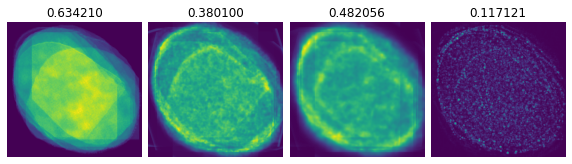

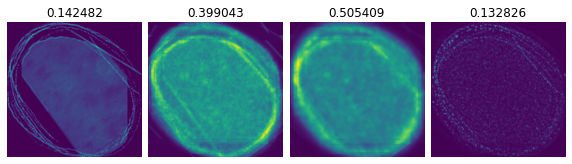

In [60]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.subplot(2,4,1)
plt.axis('off')
plt.title("{:.6f}".format(intensity00_conv1.max()))
plt.imshow(intensity00_conv1)
plt.subplot(2,4,2)
plt.axis('off')
plt.title("{:.6f}".format(intensity00_layer1.max()))
plt.imshow(intensity00_layer1)
plt.subplot(2,4,3)
plt.axis('off')
plt.title("{:.6f}".format(intensity00_layer2.max()))
plt.imshow(intensity00_layer2)
plt.subplot(2,4,4)
plt.axis('off')
plt.title("{:.6f}".format(intensity00_gb.max()))
plt.imshow(intensity00_gb)

plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.subplot(2,4,5)
plt.axis('off')
plt.title("{:.6f}".format(intensity01_conv1.max()))
plt.imshow(intensity01_conv1)
plt.subplot(2,4,6)
plt.axis('off')
plt.title("{:.6f}".format(intensity01_layer1.max()))
plt.imshow(intensity01_layer1)
plt.subplot(2,4,7)
plt.axis('off')
plt.title("{:.6f}".format(intensity01_layer2.max()))
plt.imshow(intensity01_layer2)
plt.subplot(2,4,8)
plt.axis('off')
plt.title("{:.6f}".format(intensity01_gb.max()))
plt.imshow(intensity01_gb)

## 3.1 Use CAM mask results as input image, predict by the same CNN

In [20]:
true_y = 0
img = X_VPA[0]
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(img).unsqueeze(0).to(device)
tf,pred = predict(model,input_tensor,true_y)

img = np.float32(img)/255
img = img/np.amax(img)
visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)

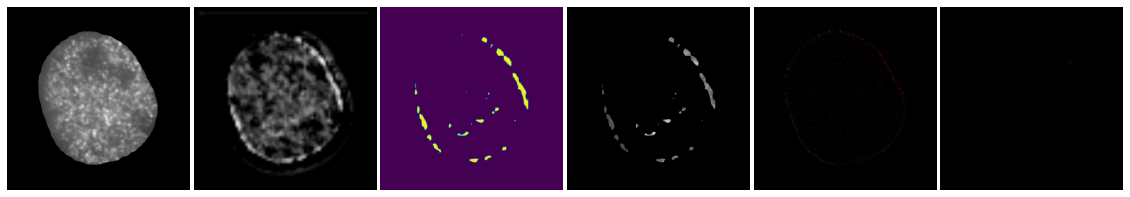

In [21]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.subplot(1,6,1)
plt.axis("off")
plt.imshow(img)
plt.subplot(1,6,2)
plt.axis("off")
plt.imshow(cam)
mask = transform(cam)[0].ge(0.5).numpy()
plt.subplot(1,6,3)
plt.axis("off")
plt.imshow(mask)
camcell = np.multiply(mask,img[:,:,0])
camcell = cv2.merge([camcell,camcell,camcell])
plt.subplot(1,6,4)
plt.axis("off")
plt.imshow(camcell)
plt.subplot(1,6,5)
plt.axis("off")
plt.imshow(gb)
plt.subplot(1,6,6)
plt.axis("off")
plt.imshow(cam_gb)

In [53]:
total = 3000
count = 0
true_y = 0
thre = 0.6
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_00[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        mask = transform(cam)[0].ge(thre).numpy()
        camcell = np.multiply(mask,img[:,:,0])
        camcell = cv2.merge([camcell,camcell,camcell])
        input_tensor = transform(camcell).unsqueeze(0).to(device)
        tf,pred = predict(model,input_tensor,true_y)
        if tf == True:
            count+=1
print("cam mask cell_00 accuracy is ", count/total)

100%|█████████████████████████████████████████████████████████| 3000/3000 [00:50<00:00, 59.85it/s]

cam mask cell_00 accuracy is  0.975


In [54]:
total = 3000
count = 0
true_y = 1
thre = 0.6
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_01Nami[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        mask = transform(cam)[0].ge(thre).numpy()
        camcell = np.multiply(mask,img[:,:,0])
        camcell = cv2.merge([camcell,camcell,camcell])
        input_tensor = transform(camcell).unsqueeze(0).to(device)
        tf,pred = predict(model,input_tensor,true_y)
        if tf == True:
            count+=1
print("cam mask cell_01Nami accuracy is ", count/total)

100%|█████████████████████████████████████████████████████████| 3000/3000 [00:49<00:00, 60.25it/s]

cam mask cell_01Nami accuracy is  0.10133333333333333


## 3.2 Use gb results as input image, predict by the same CNN

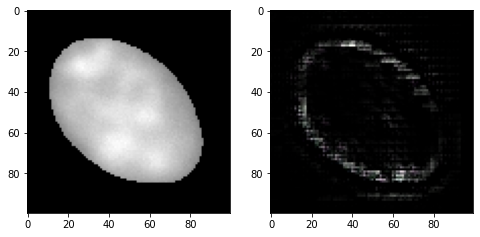

In [55]:
true_y = 0
img = Data_00[1]
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(img).unsqueeze(0).to(device)
tf,pred = predict(model,input_tensor,true_y)
img = np.float32(img)/255
img = img/np.amax(img)
visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
if tf == True:
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(gb)

In [29]:
total = 3000
count = 0
true_y = 0
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_00[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        input_tensor = transform(gb).unsqueeze(0).to(device)
        tf_gb,pred_gb = predict(model,input_tensor,true_y)
        if tf_gb == True:
            count+=1
print("gb 00 accuracy is ", count/total)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:47<00:00, 63.59it/s]

gb 00 accuracy is  0.7226666666666667


In [30]:
total = 3000
count = 0
true_y = 1
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_01Nami[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        input_tensor = transform(gb).unsqueeze(0).to(device)
        tf_gb,pred_gb = predict(model,input_tensor,true_y)
        if tf_gb == True:
            count+=1
print("gb 01 accuracy is ", count/total)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:47<00:00, 63.68it/s]

gb 01 accuracy is  0.5033333333333333


## 3.3 test CNN model by category

In [18]:
total = Data_00.shape[0]
count = 0
true_y = 0
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_00[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        count+=1
print("00 accuracy is ", count/total)
print("count/total is ", count,total)

100%|███████████████████████████████████████████████████████████████████████████████| 65969/65969 [01:38<00:00, 672.74it/s]

00 accuracy is  0.9844927162758266
count/total is  64946 65969


In [19]:
total = Data_01Nami.shape[0]
count = 0
true_y = 1
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_01Nami[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        count+=1
print("01 accuracy is ", count/total)
print("count/total is ", count,total)

100%|█████████████████████████████████████████████████████████████████████████████████| 3219/3219 [00:04<00:00, 680.00it/s]

01 accuracy is  0.9913016464740603
count/total is  3191 3219


# 99. debug

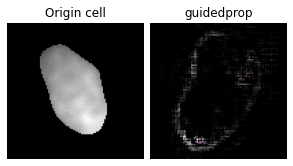

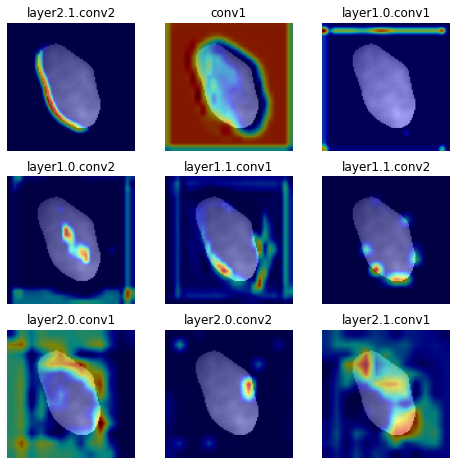

In [149]:
model_layers = [[model.conv1],[model.layer1[0].conv1],[model.layer1[0].conv2],[model.layer1[1].conv1],
                [model.layer1[1].conv2],[model.layer2[0].conv1],[model.layer2[0].conv2],
                [model.layer2[1].conv1],[model.layer2[1].conv2]]
true_y = 1
img=Data_01Nami[199]
img = np.float32(img)/255
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(img).unsqueeze(0).to("cuda")
tf,pred = predict(model,input_tensor,true_y)

img = img/np.amax(img)
layer = ["conv1","layer1.0.conv1","layer1.0.conv2","layer1.1.conv1","layer1.1.conv2",
        "layer2.0.conv1","layer2.0.conv2","layer2.1.conv1","layer2.1.conv2"]

plt.figure(figsize=(5,5))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Origin cell")
plt.imshow(img)
plt.subplot(1,2,2)
plt.axis('off')
plt.title("guidedprop")
plt.imshow(cv2.cvtColor(gb, cv2.COLOR_BGR2RGB))

i=1
plt.figure(figsize=(8,8))
for target_layers in model_layers:
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    plt.subplot(3,3,i)
    plt.axis('off')
    plt.title(layer[i-2])
    plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
    i+=1



# 98. Other code

In [103]:
class FeatureExtractor():

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x


def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input



class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
#         cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(torch.autograd.Function):

    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input),
                                   torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply
                
        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output


In [104]:
def get_gradcam_image(model, img):
    grad_cam = GradCam(model=model, feature_module=model.layer3, \
                       target_layer_names=['0'], use_cuda=True)

    img_shape = img.shape
    img = np.float32(img) / 255
    input = preprocess_image(img)

    target_index = None
    camorigin = grad_cam(input, target_index)
    mask = cv2.resize(camorigin, input.shape[2:])

    # Grad-CAM
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    img_gradcam = np.uint8(255 * cam)

    # Guided Grad-CAM
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input, index=target_index)
    gb = gb.transpose((1, 2, 0))
    cam_mask = cv2.merge([mask, mask, mask])
    cam_gb = cam_mask * gb
    cam_gb = cam_gb - np.mean(cam_gb)
    cam_gb = cam_gb / (np.std(cam_gb) + 1e-5)
    cam_gb = cam_gb * 0.1
    cam_gb = cam_gb + 0.5
    cam_gb = np.clip(cam_gb, 0, 1)
    img_ggradcam = np.uint8(cam_gb * 255)

    # gb
    gb = gb - np.mean(gb)
    gb = gb / (np.std(gb) + 1e-5)
    gb = gb * 0.1
    gb = gb + 0.5
    gb = np.clip(gb, 0, 1)
    gb = np.uint8(gb * 255)

    img_gb = cv2.resize(gb, (img_shape[1], img_shape[0]))
    img_gradcam = cv2.resize(img_gradcam, (img_shape[1], img_shape[0])) 
    img_ggradcam = cv2.resize(img_ggradcam, (img_shape[1], img_shape[0])) 

    return camorigin, mask, img_gradcam, img_gb, img_ggradcam


In [105]:
img = Data_00[10]*2
img_gradcam = get_gradcam_image(model, img)

plt.figure(figsize=(16,12))
plt.subplot(1, 6, 1)
plt.title("origin cell image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 6, 2)
plt.title("cam")
plt.imshow(cv2.cvtColor(img_gradcam[0], cv2.COLOR_BGR2RGB))
plt.subplot(1, 6, 3)
plt.title("resize cam")
plt.imshow(cv2.cvtColor(img_gradcam[1], cv2.COLOR_BGR2RGB))
plt.subplot(1, 6, 4)
plt.title("cam cell")
plt.imshow(cv2.cvtColor(img_gradcam[2], cv2.COLOR_BGR2RGB))
plt.subplot(1, 6, 5)
plt.title("gb")
plt.imshow(cv2.cvtColor(img_gradcam[3], cv2.COLOR_BGR2RGB))
plt.subplot(1, 6, 6)
plt.title("gb cam")
plt.imshow(cv2.cvtColor(img_gradcam[4], cv2.COLOR_BGR2RGB))

IndexError: list index out of range